In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error

2025-06-02 10:24:27.356120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10000)]  # MB
        )
        print("VRAM limited to 10000 MB.")
    except RuntimeError as e:
        print("Memory configuration must be set at program start:", e)

VRAM limited to 10000 MB.


2025-06-02 10:24:30.246170: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-02 10:24:33.585068: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-02 10:24:33.585160: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
def load_and_clean_csv(path):
    df = pd.read_csv(path)
    
    # Drop last 6 rows
    df = df.iloc[:-6]
    
    # Convert date column to datetime
    df['#date+time'] = pd.to_datetime(df['#date+time'], errors='coerce')
    df = df.rename(columns={'#date+time': 'date_time'})
    
    # Convert all other columns to numeric
    for col in df.columns:
        if col != 'date_time':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df
def wind_to_uv(speed, direction_deg):
    # Convert to radians
    direction_rad = np.deg2rad(direction_deg)

    # U = -speed * sin(direction), V = -speed * cos(direction)
    # This converts FROM meteorological TO Cartesian
    u = -speed * np.sin(direction_rad)
    v = -speed * np.cos(direction_rad)
    return u, v

def prepare_dataframe(df):
    # Rename columns to a consistent format
    df = df.rename(columns={
        df.columns[0]: 'date_time',
        df.columns[1]: 'pwl',
        df.columns[2]: 'wsd',
        df.columns[3]: 'wdr'
    })
    
    # Convert wind to U/V components
    u, v = wind_to_uv(df['wsd'], df['wdr'])
    df[['u', 'v']] = np.column_stack((u, v))
    
    # Drop raw wind columns
    df.drop(columns=['wsd', 'wdr'], inplace=True)
    
    return df

def input_output_arrays(source_df, target_df, wl_window, wind_window):

    wl_window = wl_window * 10
    wind_window = wind_window * 10

    source_df = source_df.reset_index(drop=True)
    target_df = target_df.reset_index(drop=True)

    source_pwl = source_df['pwl'].to_numpy()
    source_u   = source_df['u'].to_numpy()
    source_v   = source_df['v'].to_numpy()
    target_pwl = target_df['pwl'].to_numpy()

    X, y, indices = [], [], []

    for t in range(max(wl_window, wind_window), len(source_df) - wl_window):
        # Water level window: centered at t
        wl_slice = slice(t - wl_window, t + wl_window + 1)

        # Wind window: past `wind_window` values ending at t
        wind_slice = slice(t - wind_window + 1, t + 1)

        pwl_input = source_pwl[wl_slice]
        u_input = source_u[wind_slice]
        v_input = source_v[wind_slice]
        target = target_pwl[t]

        if (
            np.isnan(pwl_input).any() or
            np.isnan(u_input).any() or
            np.isnan(v_input).any() or
            np.isnan(target)
        ):
            continue

        features = np.concatenate([pwl_input, u_input, v_input])
        X.append(features)
        y.append(target)
        indices.append(t)

    return np.array(X), np.array(y), np.array(indices)



def calculate_central_frequency_percentage(testing_label_array, predictions, cm):
  """Find the percentage of predictions with a central frequency (CF) of less than
  or equal to a given number of centimeters (cm)

	Args:
        testing_label_array (array): Testing labels

        predictions (array): Model predictions

        cm (int): Number of centimeters

	Returns:
		(float): central frequency (CF) percentage
	"""
  less_than_cm_counter = 0

  # Convert cm to m
  cm_to_m = cm / 100

  for index, prediction in enumerate(predictions):
    if abs(testing_label_array[index] - prediction) <= cm_to_m:
      less_than_cm_counter += 1

  cf_percentage = (less_than_cm_counter / len(predictions)) * 100

  return cf_percentage


def evaluate_model(model, testing_input_array, testing_label_array):
  """Calculates loss, makes predictions, and calculates Central Frequency (CF),
  Mean Squared Error (MSE), Root Mean Squared Error(RMSE), Mean Absolute Error (MAE),
  Median Absolute Error, and R-squared (R2)

	Args:
        model (tf.keras.model): The trained model

        testing_input_array (array): Testing inputs

        testing_label_array (array): Testing labels
	"""
  print("Calculating Loss:")
  test_loss = model.evaluate(testing_input_array, testing_label_array, batch_size = len(testing_input_array))

  print("Loss:", test_loss)


  print("\nGenerating output predictions with model:")
  predictions = model.predict(testing_input_array, batch_size = len(testing_input_array))

  # Calculate evaluation metrics
  cf_15cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 15)
  cf_5cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 5)
  cf_1cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 1)
  mse = mean_squared_error(testing_label_array, predictions)
  rmse = root_mean_squared_error(testing_label_array, predictions)
  mae = mean_absolute_error(testing_label_array, predictions)
  medae = median_absolute_error(testing_label_array, predictions)
  r2 = r2_score(testing_label_array, predictions)

  print("\nCentral Frequency Percentage 15cm:", cf_15cm_percentage)
  print("\nCentral Frequency Percentage 5cm:", cf_5cm_percentage)
  print("\nCentral Frequency Percentage 1cm:", cf_1cm_percentage)
  print("Mean Squared Error:", mse)
  print("Root Mean Squared Error:", rmse)
  print("Mean Absolute Error:", mae)
  print("Median Absolute Error:", medae)
  print("R-squared:", r2)


file_paths = {
    'pi08': '/home/ryan/Downloads/pIsabel_pwl+wind_june2008-2009.csv',
    'cg08': '/home/ryan/Downloads/spiCoastGuard_pwl+wind+surge_june2008-2009.csv',
    'pi09': '/home/ryan/Downloads/pIsabel_pwl+wind+surge_mar2009-apr2010.csv',
    'cg09': '/home/ryan/Downloads/spiCoastGuard_pwl+wind+surge_mar2009-apr2010.csv',
    'pi11': '//home/ryan/Downloads/pIsabel_pwl+wind+surge_mar2011-apr2012.csv',
    'cg11': '/home/ryan/Downloads/spiCoastGuard_pwl+wind+surge_mar2011-apr2012.csv',

}

datasets = {key: load_and_clean_csv(path) for key, path in file_paths.items()}

for name, df in datasets.items():
    datasets[name] = prepare_dataframe(df)


In [32]:
X_train, y_train, indices_train = input_output_arrays(datasets['cg08'], datasets['pi08'], wl_window=3, wind_window=3)
X_val, y_val, indices_val = input_output_arrays(datasets['cg09'], datasets['pi09'], wl_window=3, wind_window=3)
X_test, y_test, indices_test = input_output_arrays(datasets['cg11'], datasets['pi11'], wl_window=3, wind_window=3)
print(X_train.shape, y_train.shape)


(60689, 121) (60689,)


In [33]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(1, kernel_initializer = 'normal' ))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [34]:
epochs = 1000

batch_size = len(X_train)
val_batch_size = len(X_val)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)

file_name = 'nev_test.keras'
checkpoint = ModelCheckpoint(file_name, monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [early_stopping, checkpoint]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    validation_batch_size=val_batch_size,
    callbacks=callbacks,
    verbose=1
)

model.summary()

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - loss: 2.5496 - mae: 1.5800
Epoch 1: val_loss improved from inf to 2.42555, saving model to nev_test.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.5496 - mae: 1.5800 - val_loss: 2.4256 - val_mae: 1.5442
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.4539 - mae: 1.5501
Epoch 2: val_loss improved from 2.42555 to 2.33133, saving model to nev_test.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 2.4539 - mae: 1.5501 - val_loss: 2.3313 - val_mae: 1.5139
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.3592 - mae: 1.5199
Epoch 3: val_loss improved from 2.33133 to 2.23684, saving model to nev_test.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 2.3592 - mae: 1.5199 - val_loss: 2.2368 - val_mae: 1.4829
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.2639 - mae: 1.4889
Epoch 4: val_loss improved from 2.23684 to 2.14165, saving model to nev_test.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step 

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 20)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,385 (28.85 KB)

 Trainable params: 2,461 (9.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,924 (19.24 KB)

In [35]:
evaluate_model(model, X_test, y_test)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.0014 - mae: 0.0304
Loss: [0.0013901694910600781, 0.030365364626049995]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step

Central Frequency Percentage 15cm: 99.99128713857183

Central Frequency Percentage 5cm: 78.92234351078528

Central Frequency Percentage 1cm: 21.26187127369587
Mean Squared Error: 0.0013901694052775896
Root Mean Squared Error: 0.03728497559711672
Mean Absolute Error: 0.030365365031705043
Median Absolute Error: 0.026439902305603002
R-squared: 0.95084334623773


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


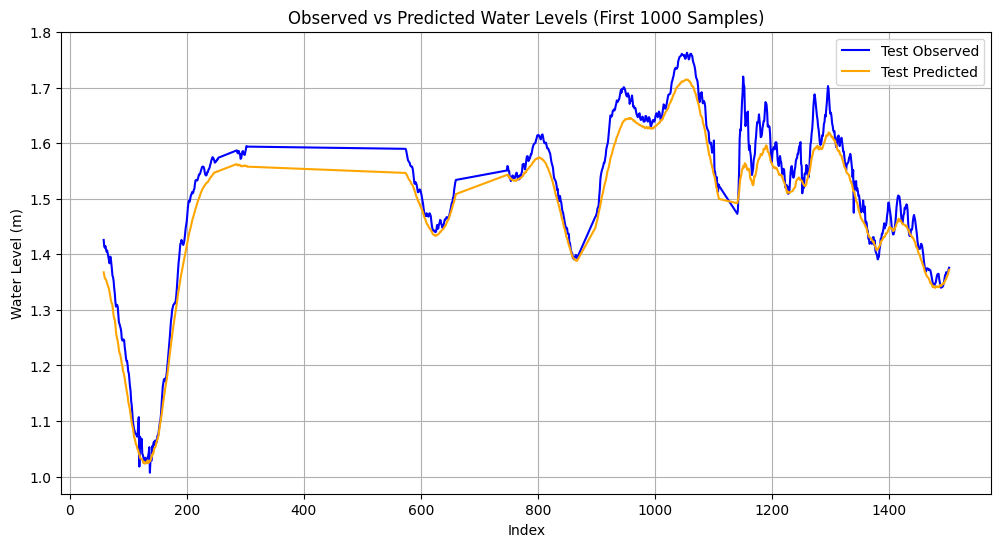

In [36]:
#plot time series of observed vs predicted over first 1000 indices of test set
predictions = model.predict(X_test, batch_size=len(X_test))
plt.figure(figsize=(12, 6))
plt.plot(indices_test[:1000], y_test[:1000], label='Test Observed', color='blue')
plt.plot(indices_test[:1000], predictions[:1000], label='Test Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('Water Level (m)')
plt.title('Observed vs Predicted Water Levels (First 1000 Samples)')
plt.legend()
plt.grid()
plt.show()